# Notebook for testing flux limits

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

file = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
data = pd.DataFrame(file) # 30,911 galaxies
data = data[data['Use'] == 1] # 13,299 galaxies
data = data[data['FKs'] > 0] # 12,676 galaxies # drop rows if FKs is negative

### Luminosity-distance relationship

1) Calculate the luminosity of each galaxy given the parameters of: $D$ the distance in $m$ to the galaxy, the flux $F$ received from the galaxy in ${W}/{m^2}/Hz$, and $z$ the redshift of the galaxy to get luminosity $L$ in $W/m^2$

$$
L = \frac{4 \pi d^2 F}{1 + z}
$$

2) Once the luminosity of each galaxy has been calculated, rearrange equation 1 to calculate the maximum redshift. This equation uses the same distance $D$ and luminosity $L$ as in equation 1) but with a new $F$: the flux limit of survey, $F_{lim}$. This effectively calculates the maximum possible redshift of the galaxy if it's flux were at the survey limit.

$$
z = \frac{4 \pi d^2 F}{L} - 1
$$


In [50]:
flux = data['FKs'] # apparent magnitude
flux = 25 - 2.5*np.log10(flux) # apparent magnitude -> AB magnitude
flux *= 1e-32 # AB magnitude uJy -> W/m^2/Hz

flux_limit = 27 # AB magitude
flux_limit *= 1e-32 # AB magnitude uJy -> W/m^2/Hz

z = data['zpk'] # redshift (unitless)
distance = cosmo.luminosity_distance(z) # Mpc
distance *= 3.086 * 10 ** 22 # Mpc -> m

luminosity = (4 * np.pi * (distance ** 2) * flux / (1 + z)) # m^2 * W/m^2/Hz = W/Hz

z_max = ((4 * np.pi * (distance ** 2) * flux_limit) / luminosity) - 1 # m^2 * W/m^2/Hz / W/Hz = redshift (unitless)

# d_max = np.sqrt((luminosity * (1 +z)) / (4 * np.pi * flux_limit)) # sqrt((W/Hz) / (W/m^2/Hz)) = m 

luminosity = np.log10(luminosity) # W/Hz -> log10(Watts/Hz)

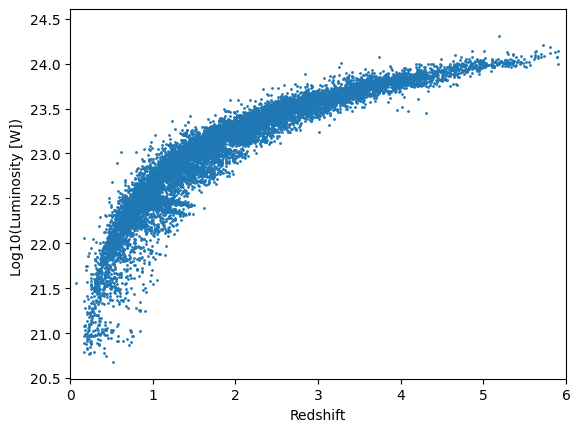

In [51]:
plt.scatter(z_max, luminosity, s=1)
plt.xlabel('Redshift')
plt.ylabel('Log10(Luminosity [W]) ')
plt.xlim(0, 6)
plt.show()